## Playing with Regression

This notebook will help us with testing different regression techniques, and eventually, test COBRA. 

So for now we will generate a random data-set and try some of the popular regression techniques on it, after it has been loaded to COBRA.

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import numpy as np
import pyCOBRA

#### Setting up data set

In [2]:
# setting up our random data-set
rng = np.random.RandomState(42)

# D1 = train machines; D2 = create COBRA; D3 = calibrate epsilon, alpha; D4 = testing
n_features = 2
D1, D2, D3, D4 = 200, 200, 200, 200
D = D1 + D2 + D3 + D4
X = np.random.uniform(-1, 1, D * n_features).reshape(D, n_features)
# Y = np.power(X[:,1], 2) + np.power(X[:,3], 3) + np.exp(X[:,10]) 
Y = np.power(X[:,0], 2) + np.power(X[:,1], 3)

# training data-set
X_train = X[:D1 + D2]
X_test = X[D1 + D2 + D3:D1 + D2 + D3 + D4]
X_eps = X[D1 + D2:D1 + D2 + D3]
# for testing
Y_train = Y[:D1 + D2]
Y_test = Y[D1 + D2 + D3:D1 + D2 + D3 + D4]
Y_eps = Y[D1 + D2:D1 + D2 + D3]

### Setting up COBRA

In [3]:
# set up our COBRA machine with the data
cobra = pyCOBRA.COBRA(train_design=X_train, train_responses=Y_train, epsilon = 0.5)

In [4]:
# we're now going to split our dataset into two parts
# shuffle data points
cobra.shuffle_data()
cobra.split_data(D1, D1 + D2)

In [5]:
# load the default machines to COBRA
cobra.loadDefault()

We note here that further machines can be loaded using either the `loadMachine()` and `loadSKMachine()` methods. The only prerequisite is that the machine has a valid `predict()` method.

## Using COBRA's machines

We've created our random dataset and now we're going to use the default sci-kit machines to see what the results look like.

In [6]:
query = X_test[9].reshape(1, -1)

In [7]:
cobra.machines

{'lasso': LassoLars(alpha=1.0, copy_X=True, eps=2.2204460492503131e-16,
      fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
      positive=False, precompute='auto', verbose=False),
 'random_forest': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'tree': DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')}

In [8]:
cobra.machines['lasso'].predict(query)

array([ 0.32989029])

In [9]:
cobra.machines['tree'].predict(query)

array([ 0.40257146])

In [10]:
cobra.machines['ridge'].predict(query)

array([ 0.17186219])

In [11]:
cobra.machines['random_forest'].predict(query)

array([ 0.05153078])

## Aggregate!

By using the aggregate function we can combine our predictors.
You can read about the aggregation procedure either in the original COBRA paper or look around in the source code for the algorithm.

In [12]:
cobra.load_machine_predictions()

In [13]:
cobra.predict(query, add_machine=True)

0.13918434583335779

In [14]:
Y_test[9]

0.030815915166352396

### Plotting COBRA

We use the class `COBRAdiagnostics` to plot our results, and for various visualisations.

In [15]:
cobra_diagnostics = pyCOBRA.COBRAdiagnostics(cobra=cobra, test_data=X_test, response=Y_test, load_results=True, epsilon=True)

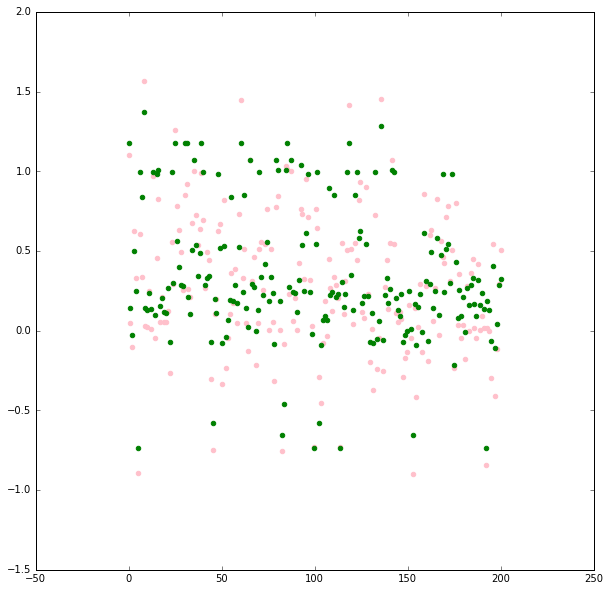

In [16]:
# to plot our machines, we need a linspace as input. This is the 'scale' to plot and should be the range of the results
# since our data ranges from -1 to 1 it is such - and we space it out to a hundred points
cobra_diagnostics.plot_machines(machine_name="COBRA")

Machine ridge is blue
Machine COBRA is green
Machine tree is red
Machine random_forest is cyan
Machine lasso is magenta


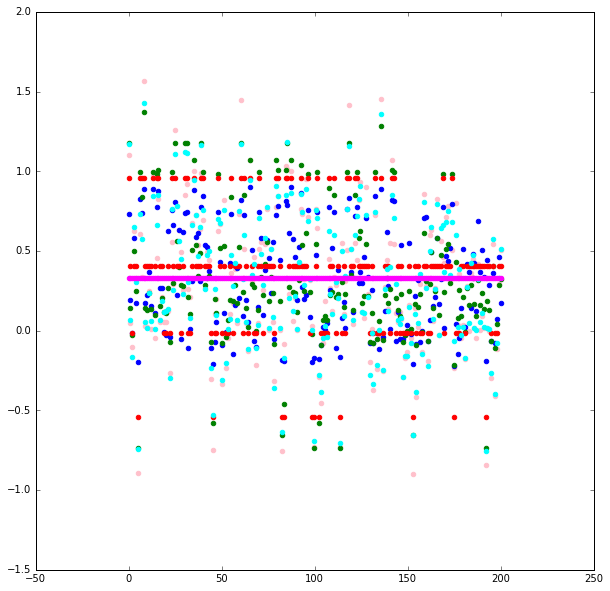

In [17]:
cobra_diagnostics.plot_machines()

More plots!
COBRA comes built in with many basic visualisation options, which we will demonstrate below.


QQ plot.

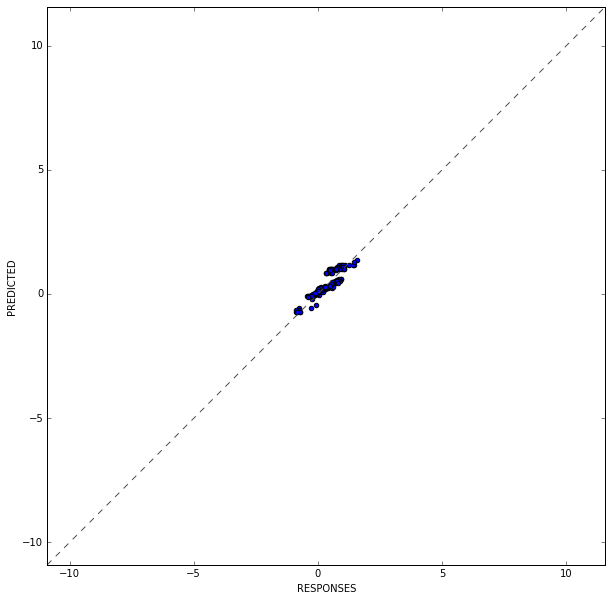

In [18]:
cobra_diagnostics.QQ(X_test, Y_test)

Let's look at each machines MSE

In [19]:
cobra_diagnostics.machine_errors()
# error of COBRA - with oracle inequality

('tree', 0.10018470048974989)
('COBRA', 0.042981231221828689)
('ridge', 0.096385945716689042)
('random_forest', 0.0085984599026399551)
('lasso', 0.20255648948258798)


### Alpha, Epsilon and Machines

The following are methods to idetify the optimal epislon values, alpha values, and combination of machines. 
The grid methods allow for us to predict for a single point the optimal alpha/machines and epsilon combination.

In [20]:
cobra_diagnostics.optimal_epsilon(X_eps, Y_eps, line_points=100)

(0.13235011333434138, 0.0066159304707664613)

In [21]:
cobra_diagnostics.optimal_alpha(X_eps, Y_eps)

(4, 0.042207684537964599)

In [22]:
cobra_diagnostics.optimal_machines(X_eps, Y_eps)

(('ridge', 'random_forest', 'lasso'), 0.038833793285180808)

In [23]:
cobra_diagnostics.optimal_alpha_grid(X_eps[0], Y_eps[0], line_points=100)

((4, 1.169092667786682), 6.9837987165064528e-07)

In [24]:
cobra_diagnostics.optimal_machines_grid(X_eps[0], Y_eps[0], line_points=100)

((('random_forest', 'lasso'), 0.13235011333434138), 1.2306928076951884e-08)

Increasing the number of line points helps in finding a better optimal value. These are the results for the same point. The MSEs are to the second value of the tuple.

With 10:
((('ridge', 'random_forest', 'lasso'), 1.1063905961135443), 0.96254542159345469)
 
With 20: 
((('tree', 'random_forest'), 0.87346626008964035), 0.53850941611803993)

With 50:
((('ridge', 'tree'), 0.94833479666875231), 0.48256303899450931)

With 100:
((('ridge', 'tree', 'random_forest'), 0.10058096328304948), 0.30285776885759158)

With 200: 
((('ridge', 'tree', 'lasso'), 0.10007553130675276), 0.30285776885759158)

### Plotting colors!

Going to experiment with plotting colors and data.
After we get information about which indices are used by which machines the best for a fixed epsilon (or not, we can toggle this option), we can plot the distribution of machines. We first present a plot where the machine colors are mixed depending on which machines were selected; after which we plot one machine at a time.

In [25]:
indices, MSE = cobra_diagnostics.indice_info(X_eps[0:200], Y_eps[0:200], epsilon=0.20)

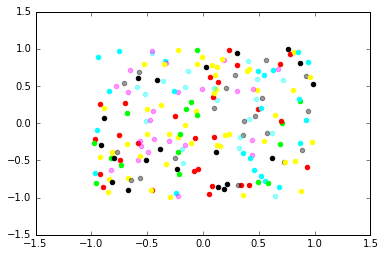

In [26]:
cobra_diagnostics.colorCobra(X_eps[0:200], indice_info=indices, single=True)

ridge
lasso
random_forest
tree


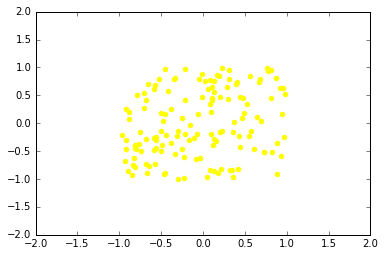

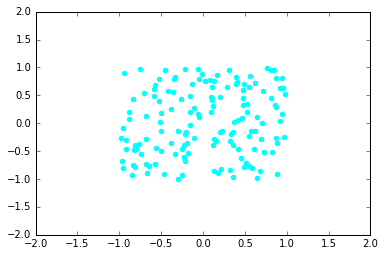

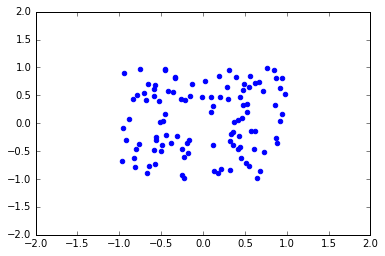

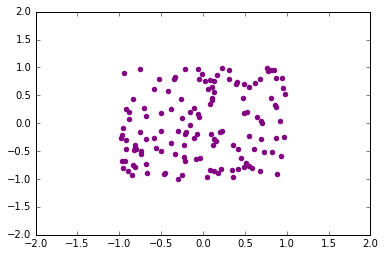

In [27]:
cobra_diagnostics.colorCobra(X_eps[0:200], indice_info=indices)

### Voronoi Tesselation

We present a variety of Voronoi Tesselation based plots - the purpose of this is to help in visualising 

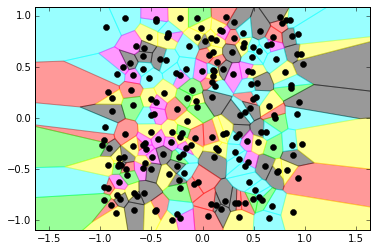

In [28]:
cobra_diagnostics.voronoi(X_eps[0:200], indice_info=indices, single=True)

ridge
lasso
random_forest
tree


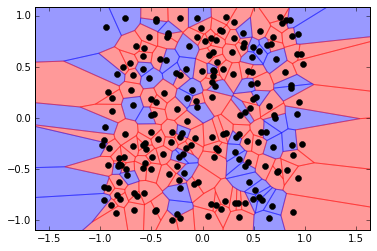

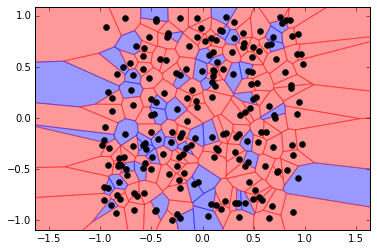

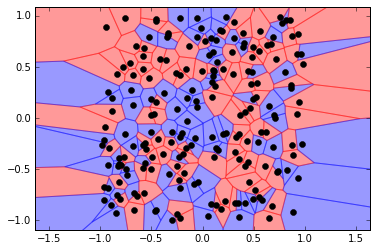

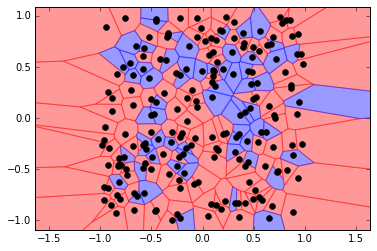

In [29]:
cobra_diagnostics.voronoi(X_eps[0:200], indice_info=indices)

### Gradient Based Voronoi

ridge
lasso
random_forest
tree


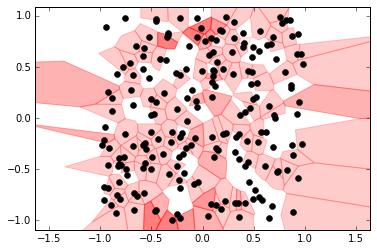

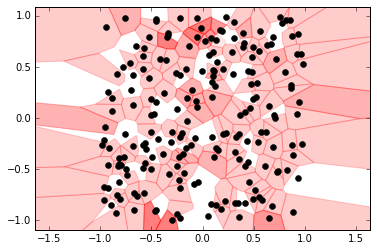

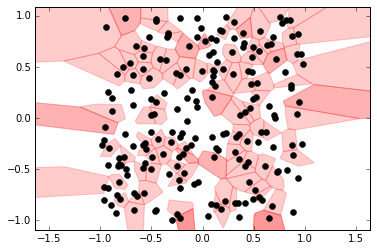

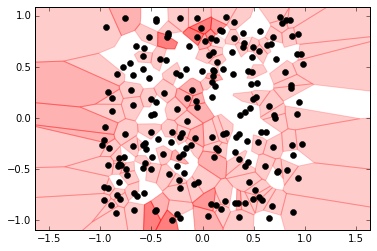

In [30]:
cobra_diagnostics.voronoi(X_eps[0:200], indice_info=indices, MSE=MSE, gradient=True)